In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load data (just after splitting)
train_images = np.load("../data/images/train_images.npy")
test_images = np.load("../data/images/test_images.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
train_tracks = np.load("../data/tracks/train_tracks.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

# Load full data

x_train_full = np.load('../data/images/time_norm_train_images.npy')[:,0,:,:]
#y_train_full = np.load('./data/labels/train_labels_augmented4.npy')
#x_test = np.load('./data/images/time_norm_test_images.npy')[:,0,:,:]
#y_test = np.load('./data/labels/test_labels.npy')

In [3]:
less_indexes = np.random.choice(np.arange(len(train_labels)), int(0.1 * len(train_labels)), replace=False)

train_tracks[less_indexes][:,0,4:17].shape

(110, 13)

In [ ]:
dataset_size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # will probably have to try with different seeds #, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9

# Will use frame 0

#### FIGURE OUT WHY IT'S NOT WORKING FOR THE NEXT SIZE, AND WHY THE TABULAR DATA HAS AN ERROR
def data_size_study(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=42):

    np.random.seed(seed)
    confusion_matrices_cellfate = np.zeros((len(dataset_size), 2, 2))
    confusion_matrices_tabular = np.zeros((len(dataset_size), 2, 2))

    for size in dataset_size:
        
        # Create new output directory folder with the size 

        output_dir=f"../results/data_labelling_study/split_{size}"
        os.makedirs(output_dir, exist_ok=True)

        less_indexes = np.random.choice(np.arange(len(train_labels)), int(size * len(train_labels)), replace=False)

        # Get less training data
        smaller_x_train_images = train_images[less_indexes]
        smaller_y_train = train_labels[less_indexes]
        smaller_x_train_tracks = train_tracks[less_indexes]

        # Augment image data
        smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

        # Stretch intensities of new images (train and test)
        stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)

        # Pick only frame zero
        x_train = stretched_x_train_smaller[:,0,:,:]
        y_train = smaller_train_labels_augmented
        x_test = stretched_x_test[:,0,:,:]
        y_test = test_labels

        print("X_train size: ", x_train.shape, "Y_train size: ", y_train.shape, "X_test size: ", x_test.shape, "Y_test size: ", y_test.shape)

        # IMAGES: Train autoencoder only
        
        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        config_clf = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
        }

        results_autoencoder = train_autoencoder(config_ae, x_train_full)
        encoder = results_autoencoder['encoder']
        decoder = results_autoencoder['decoder']
        discriminator = results_autoencoder['discriminator']

        # IMAGES: Train AIcellfate with smaller dataset

        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test) #lambda_recon=scaled_autoencoder_results['lambda_recon'], lambda_adv=scaled_autoencoder_results['lambda_adv']
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']
        discriminator = results_cellfate['discriminator']

        save_model_weights_to_disk(encoder, decoder, discriminator, output_dir=output_dir)
        
        evaluator = Evaluation(output_dir)

        # Evaluate the model (and saving everything)
        z_imgs = encoder.predict(x_train)
        recon_imgs = decoder.predict(z_imgs)
        evaluator.reconstruction_images(x_train, recon_imgs[:,:,:,0], epoch=0)
        evaluator.visualize_latent_space(z_imgs, y_train, epoch=0)
        cov_matrix = cov_loss_terms(z_imgs)[0]
        evaluator.plot_cov_matrix(cov_matrix, epoch=0) # the epoch is a placeholder, it doesnt mean anything (TODO: change these functions)

        tf.keras.utils.set_random_seed(config_clf['seed'])

        classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

        x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
        history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

        y_pred = classifier.predict(x_test_)
        y_pred_classes = np.argmax(y_pred, axis=1)
        num_classes = len(np.unique(y_test_))

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums
        
        confusion_matrices_cellfate[dataset_size.index(size)] = conf_matrix_normalized

        # Save confusion matrix
        plot_confusion_matrix(y_test_, y_pred, num_classes)
        np.save(f"{output_dir}/confusion_matrices_cellfate.npy", confusion_matrices_cellfate)

        # TODO: add perturbations ?

        # TRACKS: train classifier

        config_tracks = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': 42,
        }
        
        train_tracks_ = smaller_x_train_tracks[:,0,4:17]
        test_tracks_ = test_tracks[:,0,4:17]
        train_labels_ = smaller_y_train
        test_labels_ = test_labels

        print("Train tracks shape: ", train_tracks_.shape)

        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_.flatten()), y=train_labels_.flatten())
        class_weights = dict(enumerate(class_weights))

        tf.keras.utils.set_random_seed(seed)

        classifier = complex_mlp_classifier(latent_dim=train_tracks_.shape[1]) #[:, [3, 8]] 
        #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

        # Train the classifier
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_tracks['learning_rate']), metrics=['accuracy'])
        classifier.summary()

        x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_, test_labels_, test_size=0.5, random_state=42) # 42 random state

        history = classifier.fit(train_tracks_, train_labels_, batch_size=config_tracks['batch_size'], epochs=config_tracks['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

        y_pred = classifier.predict(x_test_tracks)

        num_classes = len(np.unique(train_labels_))
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_tracks, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        print(conf_matrix_normalized)

        confusion_matrices_tabular[dataset_size.index(size)] = conf_matrix_normalized
        np.save(f"{output_dir}/confusion_matrices_tabular.npy", confusion_matrices_tabular)

    return confusion_matrices_cellfate, confusion_matrices_tabular


#np.save("../results/data_labelling_study/smaller_x_train_images.npy", smaller_x_train_images)

X_train size:  (2184, 20, 20) Y_train size:  (2184,) X_test size:  (277, 20, 20) Y_test size:  (277,)
Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 42, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2867, Adversarial loss: 0.7489, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.7749, Adversarial loss: 0.7269, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7638, Adversarial loss: 0.7135, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7467, Adversarial loss: 0.7116, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7450, Adversarial loss: 0.7094, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7531, Adversarial loss: 0.6986, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7237, Adversarial loss: 0.7067, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7281, Adversarial loss: 0.7037, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7274, Adversarial loss: 0.6983, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6040 - loss: 0.6838 - val_accuracy: 0.6449 - val_loss: 0.6113
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6021 - loss: 0.6756 - val_accuracy: 0.6377 - val_loss: 0.6251
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.6007 - loss: 0.6698 - val_accuracy: 0.6377 - val_loss: 0.6325
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6056 - loss: 0.6470 - val_accuracy: 0.6304 - val_loss: 0.6394
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6120 - loss: 0.6475 - val_accuracy: 0.6159 - val_loss: 0.6449
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.5810 - loss: 0.6556 - val_accuracy: 0.6159 - val_loss: 0.6461
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.6026 - loss: 0.6551 - val_accuracy: 0.6304 - val_loss: 0.6456
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6014 - loss: 0.6598 - val_accuracy: 0.62

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6769 - loss: 0.6039 - val_accuracy: 0.6884 - val_loss: 0.6085
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.6665 - loss: 0.6049 - val_accuracy: 0.6812 - val_loss: 0.6094
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6692 - loss: 0.6049 - val_accuracy: 0.6812 - val_loss: 0.6072
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6714 - loss: 0.5989 - val_accuracy: 0.6667 - val_loss: 0.6076
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.6713 - loss: 0.5983 - val_accuracy: 0.6667 - val_loss: 0.6071
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6735 - loss: 0.5950 - val_accuracy: 0.6594 - val_loss: 0.6086
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6668 - loss: 0.6007 - val_accuracy: 0.6594 - val_loss: 0.6089
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6681 - loss: 0.6058 - val_accuracy: 0.6594

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6236 - loss: 0.6960 - val_accuracy: 0.7029 - val_loss: 0.5838
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6474 - loss: 0.6500 - val_accuracy: 0.6957 - val_loss: 0.5925
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.6499 - loss: 0.6287 - val_accuracy: 0.6884 - val_loss: 0.6012
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.6329 - loss: 0.6391 - val_accuracy: 0.6812 - val_loss: 0.6073
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.6575 - loss: 0.6060 - val_accuracy: 0.6594 - val_loss: 0.6132
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.6587 - loss: 0.6058 - val_accuracy: 0.6522 - val_loss: 0.6190
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.6405 - loss: 0.6250 - val_accuracy: 0.6449 - val_loss: 0.6232
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.6317 - loss: 0.6160 - val_accuracy: 0.64

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5745 - loss: 0.6940 - val_accuracy: 0.6522 - val_loss: 0.6636
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6428 - loss: 0.6524 - val_accuracy: 0.6159 - val_loss: 0.6557
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.6392 - loss: 0.6388 - val_accuracy: 0.6304 - val_loss: 0.6481
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.6438 - loss: 0.6265 - val_accuracy: 0.6232 - val_loss: 0.6427
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - accuracy: 0.6533 - loss: 0.6170 - val_accuracy: 0.6304 - val_loss: 0.6384
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.6545 - loss: 0.6159 - val_accuracy: 0.6232 - val_loss: 0.6357
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - accuracy: 0.6655 - loss: 0.6133 - val_accuracy: 0.6304 - val_loss: 0.6327
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.6552 - loss: 0.6130 - val_accuracy: 0.62

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_9 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3315 - loss: 0.9247 - val_accuracy: 0.3261 - val_loss: 0.8470
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.3268 - loss: 0.8990 - val_accuracy: 0.3261 - val_loss: 0.8140
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.3299 - loss: 0.8554 - val_accuracy: 0.3406 - val_loss: 0.7841
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.3291 - loss: 0.8110 - val_accuracy: 0.3551 - val_loss: 0.7586
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.3276 - loss: 0.7777 - val_accuracy: 0.3768 - val_loss: 0.7378
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.3290 - loss: 0.7518 - val_accuracy: 0.3841 - val_loss: 0.7193
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.3277 - loss: 0.7277 - val_accuracy: 0.4130 - val_loss: 0.7030
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.3539 - loss: 0.7067 - val_accuracy: 0.60

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5212 - loss: 0.9209 - val_accuracy: 0.5145 - val_loss: 0.8381
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.5520 - loss: 0.8435 - val_accuracy: 0.5290 - val_loss: 0.7893
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.5590 - loss: 0.8127 - val_accuracy: 0.5507 - val_loss: 0.7499
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.5816 - loss: 0.7502 - val_accuracy: 0.5870 - val_loss: 0.7166
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.5830 - loss: 0.7210 - val_accuracy: 0.5725 - val_loss: 0.6885
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.6117 - loss: 0.6861 - val_accuracy: 0.5725 - val_loss: 0.6648
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.6080 - loss: 0.6666 - val_accuracy: 0.6014 - val_loss: 0.6476
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - accuracy: 0.6227 - loss: 0.6437 - val_accuracy: 0.61

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_11 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5672 - loss: 0.9683 - val_accuracy: 0.6159 - val_loss: 0.7774
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.5558 - loss: 0.9085 - val_accuracy: 0.5870 - val_loss: 0.7801
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.5672 - loss: 0.8553 - val_accuracy: 0.5652 - val_loss: 0.7782
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.5886 - loss: 0.8032 - val_accuracy: 0.5652 - val_loss: 0.7711
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6068 - loss: 0.7700 - val_accuracy: 0.5580 - val_loss: 0.7624
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.6183 - loss: 0.7285 - val_accuracy: 0.5435 - val_loss: 0.7535
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.6077 - loss: 0.7121 - val_accuracy: 0.5580 - val_loss: 0.7402
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.6174 - loss: 0.6881 - val_accuracy: 0.57

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4075 - loss: 0.7634 - val_accuracy: 0.3333 - val_loss: 0.7633
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.4870 - loss: 0.7272 - val_accuracy: 0.4420 - val_loss: 0.7181
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.5894 - loss: 0.6828 - val_accuracy: 0.5507 - val_loss: 0.6879
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.6428 - loss: 0.6579 - val_accuracy: 0.6449 - val_loss: 0.6661
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.6901 - loss: 0.6367 - val_accuracy: 0.6667 - val_loss: 0.6519
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6729 - loss: 0.6293 - val_accuracy: 0.6884 - val_loss: 0.6409
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6747 - loss: 0.6204 - val_accuracy: 0.6812 - val_loss: 0.6338
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.6895 - loss: 0.6185 - val_accuracy: 0.67

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_13 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6375 - loss: 0.6906 - val_accuracy: 0.5797 - val_loss: 0.8271
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.6443 - loss: 0.6745 - val_accuracy: 0.5797 - val_loss: 0.7755
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6570 - loss: 0.6350 - val_accuracy: 0.5797 - val_loss: 0.7359
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.6774 - loss: 0.6083 - val_accuracy: 0.6087 - val_loss: 0.7035
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.6716 - loss: 0.6166 - val_accuracy: 0.6014 - val_loss: 0.6742
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6722 - loss: 0.6086 - val_accuracy: 0.6014 - val_loss: 0.6582
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.6757 - loss: 0.6017 - val_accuracy: 0.6014 - val_loss: 0.6478
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6851 - loss: 0.5931 - val_accuracy: 0.60

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7056 - loss: 0.6271 - val_accuracy: 0.5870 - val_loss: 0.7376
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.7007 - loss: 0.6341 - val_accuracy: 0.5942 - val_loss: 0.7089
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.7176 - loss: 0.6267 - val_accuracy: 0.5942 - val_loss: 0.6825
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.7084 - loss: 0.6007 - val_accuracy: 0.6014 - val_loss: 0.6628
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.6994 - loss: 0.6259 - val_accuracy: 0.6377 - val_loss: 0.6456
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.6995 - loss: 0.6123 - val_accuracy: 0.6522 - val_loss: 0.6318
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.6906 - loss: 0.5945 - val_accuracy: 0.6739 - val_loss: 0.6234
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.7026 - loss: 0.5880 - val_accuracy: 0.65

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_15 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6732 - loss: 0.6265 - val_accuracy: 0.6087 - val_loss: 0.7020
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6838 - loss: 0.5956 - val_accuracy: 0.6232 - val_loss: 0.6687
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.6792 - loss: 0.6024 - val_accuracy: 0.6377 - val_loss: 0.6470
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.7038 - loss: 0.5754 - val_accuracy: 0.6522 - val_loss: 0.6305
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.6868 - loss: 0.5843 - val_accuracy: 0.6449 - val_loss: 0.6185
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6828 - loss: 0.5847 - val_accuracy: 0.6449 - val_loss: 0.6098
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6819 - loss: 0.5542 - val_accuracy: 0.6449 - val_loss: 0.6075
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.7000 - loss: 0.5530 - val_accuracy: 0.65

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3994 - loss: 0.8226 - val_accuracy: 0.6014 - val_loss: 0.7091
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.4517 - loss: 0.7685 - val_accuracy: 0.5942 - val_loss: 0.7004
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.4658 - loss: 0.7508 - val_accuracy: 0.5870 - val_loss: 0.6887
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.5123 - loss: 0.7201 - val_accuracy: 0.5652 - val_loss: 0.6786
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.5600 - loss: 0.6905 - val_accuracy: 0.5725 - val_loss: 0.6679
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6199 - loss: 0.6687 - val_accuracy: 0.6304 - val_loss: 0.6585
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.6489 - loss: 0.6549 - val_accuracy: 0.6449 - val_loss: 0.6498
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.6762 - loss: 0.6356 - val_accuracy: 0.65

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_17 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4179 - loss: 0.7945 - val_accuracy: 0.6304 - val_loss: 0.6559
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.4708 - loss: 0.7422 - val_accuracy: 0.5870 - val_loss: 0.6512
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.5353 - loss: 0.6940 - val_accuracy: 0.6232 - val_loss: 0.6492
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.5852 - loss: 0.6722 - val_accuracy: 0.6087 - val_loss: 0.6480
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.6619 - loss: 0.6226 - val_accuracy: 0.5942 - val_loss: 0.6459
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.7051 - loss: 0.5985 - val_accuracy: 0.6159 - val_loss: 0.6437
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.7129 - loss: 0.5851 - val_accuracy: 0.6377 - val_loss: 0.6434
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.7395 - loss: 0.5729 - val_accuracy: 0.63

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_18 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6918 - loss: 0.8014 - val_accuracy: 0.6304 - val_loss: 0.8628
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.7028 - loss: 0.7634 - val_accuracy: 0.6232 - val_loss: 0.8427
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.7130 - loss: 0.7104 - val_accuracy: 0.6304 - val_loss: 0.8241
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.7226 - loss: 0.7015 - val_accuracy: 0.6377 - val_loss: 0.8078
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.7210 - loss: 0.6537 - val_accuracy: 0.6232 - val_loss: 0.7959
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.7275 - loss: 0.6295 - val_accuracy: 0.6449 - val_loss: 0.7805
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.7340 - loss: 0.5967 - val_accuracy: 0.6377 - val_loss: 0.7716
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.7350 - loss: 0.5715 - val_accuracy: 0.63

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_19 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2702 - loss: 1.3575 - val_accuracy: 0.3768 - val_loss: 1.1293
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.2695 - loss: 1.2426 - val_accuracy: 0.3768 - val_loss: 1.0434
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.3283 - loss: 1.1615 - val_accuracy: 0.4058 - val_loss: 0.9662
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.3609 - loss: 1.0747 - val_accuracy: 0.3986 - val_loss: 0.8987
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.3594 - loss: 0.9912 - val_accuracy: 0.4130 - val_loss: 0.8461
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.3926 - loss: 0.9290 - val_accuracy: 0.4130 - val_loss: 0.7999
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.4185 - loss: 0.8599 - val_accuracy: 0.4710 - val_loss: 0.7611
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.4218 - loss: 0.8132 - val_accuracy: 0.48

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_20 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4871 - loss: 1.2231 - val_accuracy: 0.3768 - val_loss: 1.1840
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.5148 - loss: 1.1233 - val_accuracy: 0.3696 - val_loss: 1.1102
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.5143 - loss: 1.0751 - val_accuracy: 0.3913 - val_loss: 1.0496
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.5314 - loss: 1.0010 - val_accuracy: 0.4203 - val_loss: 0.9968
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.5630 - loss: 0.9076 - val_accuracy: 0.4420 - val_loss: 0.9493
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.5662 - loss: 0.8974 - val_accuracy: 0.4783 - val_loss: 0.9077
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.5943 - loss: 0.8412 - val_accuracy: 0.5072 - val_loss: 0.8702
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.5912 - loss: 0.8055 - val_accuracy: 0.56

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_21 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3957 - loss: 1.1617 - val_accuracy: 0.3478 - val_loss: 1.0927
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.4141 - loss: 1.0519 - val_accuracy: 0.3623 - val_loss: 1.0199
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.4127 - loss: 1.0311 - val_accuracy: 0.3623 - val_loss: 0.9535
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.4254 - loss: 0.9413 - val_accuracy: 0.3841 - val_loss: 0.8987
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.4352 - loss: 0.8765 - val_accuracy: 0.3841 - val_loss: 0.8481
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.4755 - loss: 0.8021 - val_accuracy: 0.4275 - val_loss: 0.8082
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.5009 - loss: 0.7606 - val_accuracy: 0.4638 - val_loss: 0.7753
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.5258 - loss: 0.7253 - val_accuracy: 0.52

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_22 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3432 - loss: 1.2589 - val_accuracy: 0.6232 - val_loss: 0.7190
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.3746 - loss: 1.1416 - val_accuracy: 0.6087 - val_loss: 0.7373
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.4202 - loss: 1.0363 - val_accuracy: 0.5797 - val_loss: 0.7500
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.4497 - loss: 0.9593 - val_accuracy: 0.5362 - val_loss: 0.7566
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.4601 - loss: 0.9165 - val_accuracy: 0.5072 - val_loss: 0.7594
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.4965 - loss: 0.8453 - val_accuracy: 0.5072 - val_loss: 0.7567
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.5181 - loss: 0.8002 - val_accuracy: 0.5217 - val_loss: 0.7501
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.5535 - loss: 0.7537 - val_accuracy: 0.52

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_23 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5476 - loss: 0.8771 - val_accuracy: 0.5145 - val_loss: 0.8081
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.5790 - loss: 0.8002 - val_accuracy: 0.5290 - val_loss: 0.7767
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.5843 - loss: 0.7284 - val_accuracy: 0.5725 - val_loss: 0.7536
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6207 - loss: 0.6936 - val_accuracy: 0.5870 - val_loss: 0.7291
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.6259 - loss: 0.6530 - val_accuracy: 0.5797 - val_loss: 0.7109
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.6550 - loss: 0.6216 - val_accuracy: 0.5797 - val_loss: 0.6951
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.6859 - loss: 0.5987 - val_accuracy: 0.5797 - val_loss: 0.6849
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6974 - loss: 0.5683 - val_accuracy: 0.60

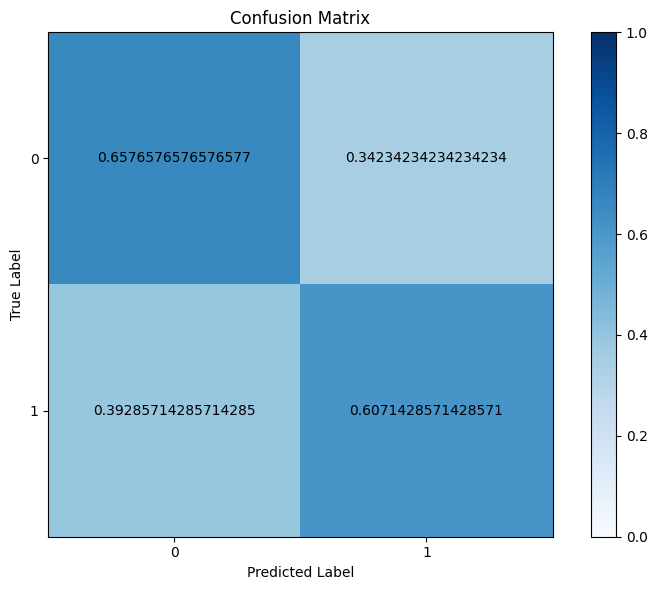

Train tracks shape:  (1108, 13)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6698 - loss: 0.7700 - val_accuracy: 0.6739 - val_loss: 0.6475
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5548 - loss: 0.7524 - val_accuracy: 0.5870 - val_loss: 0.6930
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.5781 - loss: 0.7267 - val_accuracy: 0.3478 - val_loss: 0.7189
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.5517 - loss: 0.7271 - val_accuracy: 0.3841 - val_loss: 0.7373
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.5095 - loss: 0.7333 - val_accuracy: 0.4275 - val_loss: 0.7168
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.5529 - loss: 0.7057 - val_accuracy: 0.4638 - val_loss: 0.6971
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.5683 - loss: 0.6950 - val_accuracy: 0.4638 - val_loss: 0.6878
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.5650 - loss: 0.6907 - val_accuracy: 0.4783

In [4]:
conf_matrix_cellfate, conf_matrix_tabular = data_size_study(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=42)